# Fully Convolutional Watershed Distance Transform for 3D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno

import numpy as np

import sys
sys.path.insert(0,"/home/snn/deepcell-tf")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import deepcell

In [2]:
import math
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.optimizers import SGD

from tensorflow.python.keras.utils.data_utils import get_file

from deepcell import losses
import image_gen as image_gen
from deepcell import image_generators
from deepcell import model_zoo
from deepcell.layers import TensorProduct, ReflectionPadding3D, DilatedMaxPool3D, ConvGRU2D

from deepcell.utils import train_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.training import train_model_conv


from tensorflow.python.keras.layers import MaxPool3D
from tensorflow.python.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.python.keras.layers import Conv3D, ZeroPadding3D, ConvLSTM2D, Cropping3D
from tensorflow.python.keras.layers import Input, Add, Concatenate, Flatten, Reshape
from tensorflow.python.keras.engine.input_layer import InputLayer

from tensorflow.python.keras.models import Model


from tensorflow.python.keras.regularizers import l2
from deepcell.layers import ImageNormalization2D, ImageNormalization3D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Softmax

from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

### Load the Training Data

In [3]:
# If DATA_FILE exists just run this cell

from deepcell.utils.data_utils import get_data

DATA_DIR = '/data/training_data/tracking_benchmark_data'
DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_cropped.npz')
# DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_V2_stacked.npz')

# Load Information for hardcoded image size training
seed = 1
test_size = .2
train_dict, test_dict = get_data(DATA_FILE, seed=seed, test_size=test_size)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

 -
X.shape: (642, 30, 135, 160, 1)
y.shape: (642, 30, 135, 160, 1)


### Set up filepath constants

In [4]:
# Set up other required filepaths
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)
ROOT_DIR = '/data' # mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

## Define feature net models

#### feature_net_3D is the gru analog of bn_feature_net_3D

In [5]:
def feature_net_3D(receptive_field=61,
                    n_frames=5,
                    input_shape=(5, 256, 256, 1),
                    n_features=3,
                    n_channels=1,
                    reg=1e-5,
                    n_conv_filters=64,
                    n_dense_filters=200,
                    VGG_mode=False,
                    init='he_normal',
                    norm_method='std',
                    location=False,
                    dilated=False,
                    padding=False,
                    padding_mode='reflect',
                    multires=False,
                    include_top=True,
                    temporal=None,
                    temporal_kernel_size=3):
    # Create layers list (x) to store all of the layers.
    # We need to use the functional API to enable the multiresolution mode
    x = []

    win = (receptive_field - 1) // 2
    
    if temporal == "conv":
        win_z = (n_frames - 1) // 2
    else:
        win_z = 0

    if dilated:
        padding = True

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
        time_axis = 2
        row_axis = 3
        col_axis = 4
        if not dilated:
            input_shape = (n_channels, n_frames, receptive_field, receptive_field)
    else:
        channel_axis = -1
        time_axis = 1
        row_axis = 2
        col_axis = 3
        if not dilated:
            input_shape = (n_frames, receptive_field, receptive_field, n_channels)

    x.append(Input(shape=input_shape))
    x.append(ImageNormalization3D(norm_method=norm_method,
                                  filter_size=receptive_field)(x[-1]))

    if padding:
        if padding_mode == 'reflect':
            x.append(ReflectionPadding3D(padding=(0, win, win))(x[-1]))
        elif padding_mode == 'zero':
            x.append(ZeroPadding3D(padding=(0, win, win))(x[-1]))

    if location:
        x.append(Location3D(in_shape=tuple(x[-1].shape.as_list()[1:]))(x[-1]))
        x.append(Concatenate(axis=channel_axis)([x[-2], x[-1]]))

    layers_to_concat = []

    rf_counter = receptive_field
    block_counter = 0
    d = 1

    while rf_counter > 4:
        filter_size = 3 if rf_counter % 2 == 0 else 4
        x.append(Conv3D(n_conv_filters, (1, filter_size, filter_size),
                        dilation_rate=(1, d, d), kernel_initializer=init,
                        padding='valid', kernel_regularizer=l2(reg))(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))

        block_counter += 1
        rf_counter -= filter_size - 1

        if block_counter % 2 == 0:
            if dilated:
                x.append(DilatedMaxPool3D(dilation_rate=(1, d, d),
                                          pool_size=(1, 2, 2))(x[-1]))
                d *= 2
            else:
                x.append(MaxPool3D(pool_size=(1, 2, 2))(x[-1]))

            if VGG_mode:
                n_conv_filters *= 2

            rf_counter = rf_counter // 2

            if multires:
                layers_to_concat.append(len(x) - 1)

    if multires:
        c = []
        for l in layers_to_concat:
            output_shape = x[l].get_shape().as_list()
            target_shape = x[-1].get_shape().as_list()
            time_crop = (0, 0)

            row_crop = int(output_shape[row_axis] - target_shape[row_axis])

            if row_crop % 2 == 0:
                row_crop = (row_crop // 2, row_crop // 2)
            else:
                row_crop = (row_crop // 2, row_crop // 2 + 1)

            col_crop = int(output_shape[col_axis] - target_shape[col_axis])

            if col_crop % 2 == 0:
                col_crop = (col_crop // 2, col_crop // 2)
            else:
                col_crop = (col_crop // 2, col_crop // 2 + 1)

            cropping = (time_crop, row_crop, col_crop)

            c.append(Cropping3D(cropping=cropping)(x[l]))
        x.append(Concatenate(axis=channel_axis)(c))

    x_prev_conv3d = Conv3D(n_dense_filters, (1, rf_counter, rf_counter),
                    dilation_rate=(1, d, d), kernel_initializer=init, activation='relu',
                    padding='valid', kernel_regularizer=l2(reg))(x[-1])
    x_prev_normed = BatchNormalization(axis=channel_axis)(x_prev_conv3d)
    
    print("x_prev_normed.output_shape", x_prev_normed.get_shape())
    
    x.append(Conv3D(n_dense_filters, (1, 1, 1), dilation_rate=(1, d, d),
                        kernel_initializer=init, padding='valid',
                        kernel_regularizer=l2(reg))(x_prev_normed))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    feature = Activation('relu')(x[-1])
    
    print("feature.output_shape", feature.get_shape())
    print("temporal, ", temporal)
    def __merge_temporal_features(feature, mode='conv', n_filters=256, 
                                  n_frames=3, padding=True, temporal_kernel_size=3):
        if mode == 'conv':
            x = Conv3D(n_filters, (n_frames, temporal_kernel_size, temporal_kernel_size),
                            kernel_initializer=init, padding='same', activation='relu',
                            kernel_regularizer=l2(reg))(feature)
        elif mode == 'lstm':
            x = ConvLSTM2D(filters=n_filters, kernel_size=temporal_kernel_size,
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(feature)
        elif mode == 'gru':
            x = ConvGRU2D(filters=n_filters, kernel_size=temporal_kernel_size,
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(feature)
        else:
            return feature
        temporal_feature = Add()([feature, x])
        temporal_feature_normed = BatchNormalization(axis=channel_axis)(temporal_feature)
        return temporal_feature_normed
    
    temporal_feature = __merge_temporal_features(feature, mode=temporal,
                                                n_filters=n_dense_filters, n_frames=n_frames, 
                                                padding=padding, temporal_kernel_size=temporal_kernel_size)

    x.append(temporal_feature)

    x.append(TensorProduct(n_dense_filters, kernel_initializer=init,
                           kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(TensorProduct(n_features, kernel_initializer=init,
                           kernel_regularizer=l2(reg))(x[-1]))

    if not dilated:
        x.append(Flatten()(x[-1]))

    if include_top:
        x.append(Softmax(axis=channel_axis)(x[-1]))

    model = Model(inputs=x[0], outputs=x[-1])
    model.summary()
    return model

#### feature_net_skip_3D is the gru analog of bn_feature_net_skip_3D

In [6]:
def feature_net_skip_3D(receptive_field=61,
                        input_shape=(5, 256, 256, 1),
                        fgbg_model=None,
                        temporal=None,
                        temporal_kernel_size=3,
                        last_only=True,
                        n_skips=1,
                        norm_method='whole_image',
                        padding_mode='reflect',
                        **kwargs):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    inputs = Input(shape=input_shape)
    img = ImageNormalization3D(norm_method=norm_method,
                               filter_size=receptive_field)(inputs)

    models = []
    model_outputs = []
    
    if fgbg_model is not None:
        for layer in fgbg_model.layers:
            layer.trainable = False
        models.append(fgbg_model)
        fgbg_output = fgbg_model(inputs)
        if isinstance(fgbg_output, list):
            fgbg_output = fgbg_output[-1]
        model_outputs.append(fgbg_output)

    for _ in range(n_skips + 1):
        if model_outputs:
            model_input = Concatenate(axis=channel_axis)([img, model_outputs[-1]])
        else:
            model_input = img

        new_input_shape = model_input.get_shape().as_list()[1:]
        models.append(feature_net_3D(receptive_field=receptive_field, 
                                     input_shape=new_input_shape, 
                                     norm_method=None, 
                                     dilated=True, 
                                     padding=True, 
                                     padding_mode=padding_mode, 
                                     temporal=temporal, 
                                     temporal_kernel_size=temporal_kernel_size, 
                                     **kwargs))
        model_outputs.append(models[-1](model_input))

    if last_only:
        model = Model(inputs=inputs, outputs=model_outputs[-1])
    elif fgbg_model is None:
        model = Model(inputs=inputs, outputs=model_outputs)
    else:
        model = Model(inputs=inputs, outputs=model_outputs[1:])
        
    model.summary()
    return model

#### Test Generator

In [9]:
DataGenerator = image_generators.MovieDataGenerator

datagen = DataGenerator(
    rotation_range=180,
    shear_range=False,
    zoom_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = DataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)


train_data = datagen.flow(
    train_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

val_data = datagen_val.flow(
    test_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

(642, 30, 135, 160, 1)
Image number: 456
Frame number: 8


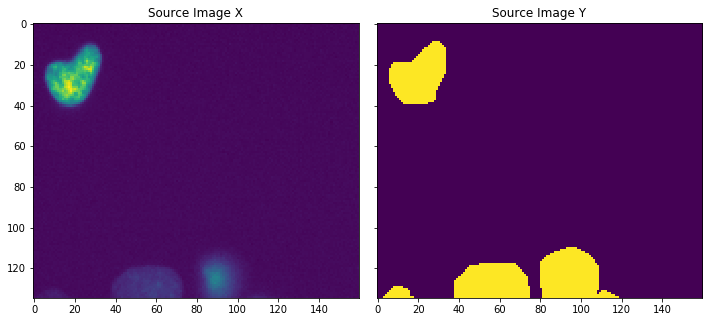

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

print(train_data.x.shape)

index = np.random.randint(low=0, high=train_data.x.shape[0])
frame = np.random.randint(low=0, high=train_data.x.shape[1])
print('Image number:', index)
print('Frame number:', frame)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(train_data.x[index, frame, ..., 0])
ax[0].set_title('Source Image X')

ax[1].imshow(train_data.y[index, frame, ..., 1])
ax[1].set_title('Source Image Y')

fig.tight_layout()
plt.show()

## Train the Model

### Training Parameters

In [15]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'trackingSEG_cropped_residual_gru_fgbg_model_10e_noreset'
conv_model_name = 'trackingSEG_cropped_residual_gru_watershed_model_10e_noreset'

n_epoch = 5  # Number of training epochs
norm_method = 'whole_image'  # data normalization - `whole_image` for 3d conv
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 0  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4  # number of distance classes
erosion_width = 1  # erode edges, improves segmentation when cells are close

# 3D Settings
frames_per_batch = 3

# Temporal Settings
temporal = "gru"
temporal_kernel_size = 3

### Foreground Background Model

#### (1) Instantiate the fgbg model

In [16]:
fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
            last_only=False,
            norm_method=norm_method)

x_prev_normed.output_shape (?, 3, 135, 160, 128)
feature.output_shape (?, 3, 135, 160, 128)
temporal,  gru
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d_21 (Image (None, 3, 135, 160,  0           input_22[0][0]                   
__________________________________________________________________________________________________
reflection_padding3d_10 (Reflec (None, 3, 195, 220,  0           image_normalization3d_21[0][0]   
__________________________________________________________________________________________________
conv3d_80 (Conv3D)              (None, 3, 192, 217,  544         reflection_padding3d_10[0][0]    
__

In [17]:
fgbg_model.load_weights('/data/models/trackingSEG_cropped_residual_gru_fgbg_model_5e_noreset.h5')

#### (2) Train the fgbg model

In [18]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
        model=fgbg_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=fgbg_model_name,
        log_dir=LOG_DIR,
        transform='fgbg',
        optimizer=optimizer,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch,
        n_epoch=n_epoch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

fgbg_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
fgbg_model.save_weights(fgbg_weights_file)

X_train shape: (642, 30, 135, 160, 1)
y_train shape: (642, 30, 135, 160, 1)
X_test shape: (161, 30, 135, 160, 1)
y_test shape: (161, 30, 135, 160, 1)
Output Shape: (None, 3, 135, 160, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/5
641/642 [============================>.] - ETA: 0s - loss: 0.1090 - acc: 0.9630
Epoch 00001: val_loss improved from inf to 0.13032, saving model to /data/models/trackingSEG_cropped_residual_gru_fgbg_model_10e_noreset.h5
642/642 [==============================] - 87s 135ms/step - loss: 0.1090 - acc: 0.9629 - val_loss: 0.1303 - val_acc: 0.9625
Epoch 2/5
641/642 [============================>.] - ETA: 0s - loss: 0.1084 - acc: 0.9623
Epoch 00002: val_loss improved from 0.13032 to 0.10964, saving model to /data/models/trackingSEG_cropped_residual_gru_fgbg_model_10e_noreset.h5
642/642 [==============================] - 77s 119ms/step - loss: 0.1084 - acc: 0.9623 - val_loss: 0.1096 - val_acc: 0.9648
Epoch 3/5
641/642 [============================>.] - ETA: 0s 

### Watershed energy transform

#### (1) Load weights for fgbg model if necessary

In [13]:
fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
            last_only=False,
            )

fgbg_model.load_weights('/data/models/trackingSEG_cropped_non_temporal_fgbg_model_5e.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d_15 (Image (None, 3, 135, 160,  0           input_16[0][0]                   
__________________________________________________________________________________________________
model_15 (Model)                (None, 3, 135, 160,  213570      image_normalization3d_15[0][0]   
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 3, 135, 160,  0           image_normalization3d_15[0][0]   
                                                                 model_15[1][0]                   
__________

#### (2) Instantiate the distance transform model 

In [19]:
watershed_model = feature_net_skip_3D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,  # (background edge, interior edge, cell interior, background)
    n_frames=frames_per_batch,
    n_conv_filters=32,
    n_dense_filters=128,
    temporal=temporal,
    temporal_kernel_size=temporal_kernel_size,
    multires=False,
    last_only=False,
    input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
    norm_method=norm_method)

x_prev_normed.output_shape (?, 3, 135, 160, 128)
feature.output_shape (?, 3, 135, 160, 128)
temporal,  gru
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d_23 (Image (None, 3, 135, 160,  0           input_24[0][0]                   
__________________________________________________________________________________________________
reflection_padding3d_11 (Reflec (None, 3, 195, 220,  0           image_normalization3d_23[0][0]   
__________________________________________________________________________________________________
conv3d_88 (Conv3D)              (None, 3, 192, 217,  1568        reflection_padding3d_11[0][0]    
__

In [20]:
watershed_model.load_weights('/data/models/trackingSEG_cropped_residual_gru_watershed_model_5e_noreset.h5')

#### (3) Train the distance transform model

In [21]:
watershed_model = train_model_conv(
        model=watershed_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=conv_model_name,
        test_size=test_size,
        seed=seed,
        transform=transform,
        distance_bins=distance_bins,
        erosion_width=erosion_width,
        optimizer=optimizer,
        batch_size=batch_size,
        n_epoch=n_epoch,
        frames_per_batch=frames_per_batch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

watershed_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(conv_model_name))
watershed_model.save_weights(watershed_weights_file)

X_train shape: (642, 30, 135, 160, 1)
y_train shape: (642, 30, 135, 160, 1)
X_test shape: (161, 30, 135, 160, 1)
y_test shape: (161, 30, 135, 160, 1)
Output Shape: (None, 3, 135, 160, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/5
641/642 [============================>.] - ETA: 0s - loss: 0.6514 - acc: 0.8846
Epoch 00001: val_loss improved from inf to 0.60724, saving model to /data/models/trackingSEG_cropped_residual_gru_watershed_model_10e_noreset.h5
642/642 [==============================] - 117s 182ms/step - loss: 0.6513 - acc: 0.8846 - val_loss: 0.6072 - val_acc: 0.8880
Epoch 2/5
641/642 [============================>.] - ETA: 0s - loss: 0.6361 - acc: 0.8854
Epoch 00002: val_loss improved from 0.60724 to 0.60429, saving model to /data/models/trackingSEG_cropped_residual_gru_watershed_model_10e_noreset.h5
642/642 [==============================] - 105s 163ms/step - loss: 0.6359 - acc: 0.8855 - val_loss: 0.6043 - val_acc: 0.8636
Epoch 3/5
641/642 [============================>.

# Run the model

#### Make predictions on test data

In [94]:
temporal = "conv"

raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
trks = load_trks(raw_trks_HEK)
lineages, X_test, y_test = trks['lineages'], trks['X'], trks['y']

run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple(X_test.shape[1:]),
            last_only=False,
            norm_method=norm_method)

run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_fgbg_model_5e.h5')

run_watershed_model = feature_net_skip_3D(
                        fgbg_model=run_fgbg_model,
                        receptive_field=receptive_field,
                        n_skips=n_skips,
                        n_features=distance_bins,
                        n_frames=frames_per_batch,
                        n_conv_filters=32,
                        n_dense_filters=128,
                        multires=False,
                        last_only=False,
                        input_shape=tuple(X_test.shape[1:]),
                        norm_method=norm_method,
                        temporal=temporal,
                        temporal_kernel_size=temporal_kernel_size)

run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_watershed_model_5e.h5')

temporal,  conv
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 30, 135, 160, 1)   0         
_________________________________________________________________
image_normalization3d_64 (Im (None, 30, 135, 160, 1)   0         
_________________________________________________________________
reflection_padding3d_28 (Ref (None, 34, 195, 220, 1)   0         
_________________________________________________________________
conv3d_252 (Conv3D)          (None, 34, 192, 217, 32)  544       
_________________________________________________________________
batch_normalization_288 (Bat (None, 34, 192, 217, 32)  128       
_________________________________________________________________
activation_284 (Activation)  (None, 34, 192, 217, 32)  0         
_________________________________________________________________
conv3d_253 (Conv3D)          (None, 34, 190, 215, 32)  9248 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_66 (InputLayer)           (None, 30, 135, 160, 0                                            
__________________________________________________________________________________________________
image_normalization3d_65 (Image (None, 30, 135, 160, 0           input_66[0][0]                   
__________________________________________________________________________________________________
model_64 (Model)                (None, 30, 135, 160, 213570      input_66[0][0]                   
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 30, 135, 160, 0           image_normalization3d_65[0][0]   
                                                                 model_64[1][0]                   
__________

In [95]:
# make predictions on testing data
test_images = run_watershed_model.predict(X_test[:1, :, :, :, :])# [-1]
test_images_fgbg = run_fgbg_model.predict(X_test[:1, :, :, :, :])# [-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1, 30, 135, 160, 4)
segmentation mask shape: (1, 30, 135, 160, 2)


### Watershed post-processing

In [90]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (1, 30, 135, 160, 1)


In [91]:
# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [92]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops

watershed_images = []
perimeter_area_threshold = 2
foreground = argmax_images_post_fgbg > 0
small_objects_threshold = 100

n_movies = argmax_images_post_fgbg.shape[0]
n_frames = argmax_images_post_fgbg.shape[1]

for i in range(n_movies):
    watershed_frames = []
    for j in range(n_frames):
        image = fg_thresh[i,j,...,0]
        semantic = fg_thresh[i,j,...]
        distance = argmax_images_post_fgbg[i,j,...,0]
        
        markers = label(distance == 3)
        labels = watershed(-distance, markers, mask=image)
        watershed_frames.append(labels)
    watershed_images.append(np.stack(watershed_frames, axis=0))

watershed_images = np.stack(watershed_images, axis=0)
watershed_images = np.expand_dims(watershed_images, axis=-1)
# for i in range(argmax_images_post_fgbg.shape[0]):
#     image = fg_thresh[i, ..., 0]
#     semantic = fg_thresh[i]
#     distance = argmax_images_post_fgbg[i, ..., 0]

#     markers = label(distance == 3)
#     local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
#                                 exclude_border=False, indices=False, labels=image)

#     markers = label(local_maxi)
#     labels = watershed(-distance, markers, mask=image)
    
#     watershed_images.append(labels)
    

#     semantic_argmax = argmax_images[i]
    
#     watershed_sub_array = []
#     for i, segments_semantic in enumerate(segments):
#         masks_concat = image[i:i+1]
#         markers_semantic = markers[i]

#         # Remove misshapen watershed cells
#         props = regionprops(segments_semantic)
#         for prop in props:
#             if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
#                 segments_semantic[segments_semantic == prop.label] = 0

#         masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
#                                    semantic.shape[1], semantic.shape[2]))
        
#         for j in range(0, masks_semantic.shape[0] + 1):
#             masks_semantic[j - 1] = segments_semantic == j
            
#         masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
#         # print("masks_concat", masks_concat.shape)
#         label_image = np.sum(masks_concat, axis=0).astype(int)
#         # print("label_image", label_image.shape)
#         # Remove small objects
#         label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
#         # Relabel the label image
#         label_image = label(label_image)
#         # print("label_image", label_image.shape)
#         watershed_sub_array.append(label_image)
#     watershed_images.append(watershed_sub_array)
        
# watershed_images = np.array(watershed_images)
# watershed_images = np.expand_dims(watershed_images, axis=-1)


### Plot the Results

Image number: 0
Frame: 24
(135, 160)


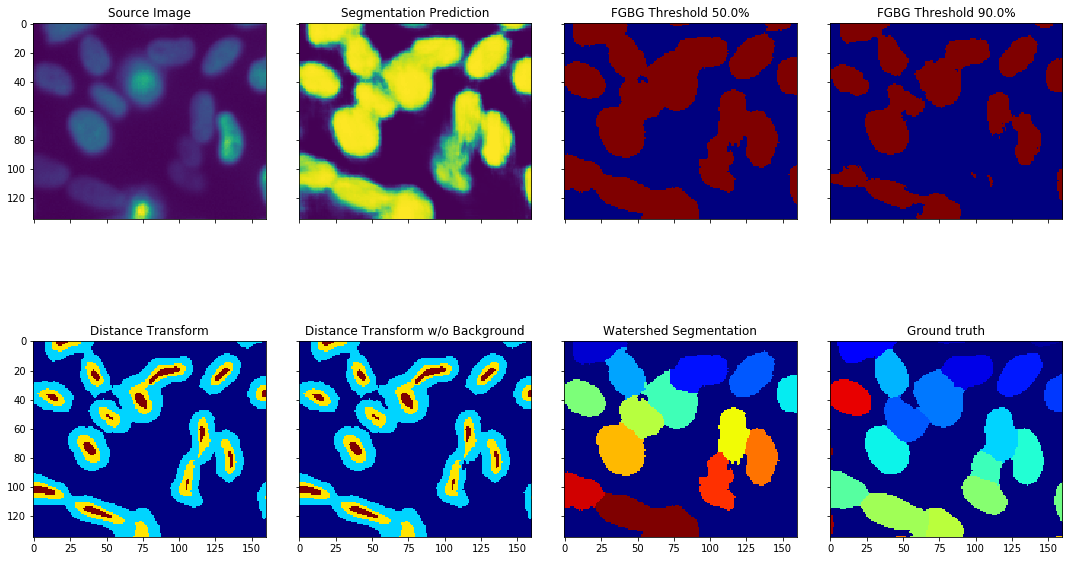

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

index = np.random.randint(low=0, high=1)
frame = np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)

print(markers.shape)

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

fg_thresh_90 = test_images_fgbg[..., 1] > 0.9
fg_thresh_90 = np.expand_dims(fg_thresh_90.astype('int16'), axis=-1)
ax[3].imshow(fg_thresh_90[index, frame, ..., 0], cmap='jet')
ax[3].set_title('FGBG Threshold {}%'.format(0.9 * 100))

ax[4].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform')

ax[5].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Distance Transform w/o Background')

ax[6].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[6].set_title('Watershed Segmentation')

ax[7].imshow(y_test[index, frame, ..., 0], cmap='jet')
ax[7].set_title('Ground truth')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Run the Model Iteratively

In [12]:
# Define the Datasets

###### For Deepcell Datasets

# Define data to load (raw images from trk test files)
RAW_BASE_DIR = '/data/training_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

# raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa]
raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa, raw_trks_RAW]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [22]:
# Make predictions on test data
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa']
CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa', 'RAW264']
temporal = "gru"
temporal_kernel_size = 3

perimeter_area_threshold = 2

# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.9
Lstats_AllDatasets = []

# Go through each Dataset (3T3, HEK293, HeLa, RAW264.7)
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    lineages, raw, tracked = trks['lineages'], trks['X'], trks['y']
    
    run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple(trks['X'].shape[1:]),
            last_only=False,
            norm_method=norm_method)

    run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_residual_gru_fgbg_model_10e_noreset.h5')

    run_watershed_model = feature_net_skip_3D(
                        fgbg_model=run_fgbg_model,
                        receptive_field=receptive_field,
                        n_skips=n_skips,
                        n_features=distance_bins,
                        n_frames=frames_per_batch,
                        n_conv_filters=32,
                        n_dense_filters=128,
                        multires=False,
                        last_only=False,
                        input_shape=tuple(trks['X'].shape[1:]),
                        norm_method=norm_method,
                        temporal=temporal,
                        temporal_kernel_size=temporal_kernel_size)

    run_watershed_model.load_weights('/data/models/trackingSEG_cropped_residual_gru_watershed_model_10e_noreset.h5')
    
    Lstats_allmovies = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):
        print("batch_num: ", batch_num)
        Lstats = []
        
        # Predict on the raw data
        X_test_temp = np.expand_dims(movie, axis=0)
        y_test_temp = np.expand_dims(trks['y'][batch_num], axis=0)
        print("X_test_temp.shape", X_test_temp.shape)
        test_images = run_watershed_model.predict(X_test_temp) #[-1]
        test_images_fgbg = run_fgbg_model.predict(X_test_temp) #[-1]
        # 
        # Postprocessing
        # Collapse predictions into semantic segmentation mask
        argmax_images = []
        for frame_num, frame in enumerate(test_images):
            max_image = np.argmax(frame, axis=-1)
            argmax_images.append(max_image)
        argmax_images = np.array(argmax_images)
        argmax_images = np.expand_dims(argmax_images, axis=-1)
        
        # threshold the foreground/background
        # and remove background from watershed transform
        fg_thresh = test_images_fgbg[..., 1] > threshold
        fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
        argmax_images_post_fgbg = argmax_images * fg_thresh
        watershed_images = []
        
        n_movies = argmax_images_post_fgbg.shape[0]
        n_frames = argmax_images_post_fgbg.shape[1]
        
        for i in range(n_movies):
            watershed_frames = []
            for j in range(n_frames):
                image = fg_thresh[i,j,...,0]
                semantic = fg_thresh[i,j,...]
                distance = argmax_images_post_fgbg[i,j,...,0]

                markers = label(distance == 3)
                labels = watershed(-distance, markers, mask=image)
                watershed_frames.append(labels)
            watershed_images.append(np.stack(watershed_frames, axis=0))

        watershed_images = np.stack(watershed_images, axis=0)
        watershed_images = np.expand_dims(watershed_images, axis=-1)

#         for i in range(argmax_images_post_fgbg.shape[0]):
#             image = fg_thresh[i, ..., 0]
#             semantic = fg_thresh[i]
#             distance = argmax_images_post_fgbg[i, ..., 0]

#             local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
#                                         exclude_border=False, indices=False, labels=image)

#             markers = label(local_maxi)
#             segments = watershed(-distance, markers, mask=image)


#             semantic_argmax = argmax_images[i]

#             watershed_sub_array = []
#             for i, segments_semantic in enumerate(segments):
#                 masks_concat = image[i:i+1]
#                 markers_semantic = markers[i]

#                 # Remove misshapen watershed cells
#                 props = regionprops(segments_semantic)
#                 for prop in props:
#                     if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
#                         segments_semantic[segments_semantic == prop.label] = 0

#                 masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
#                                            semantic.shape[1], semantic.shape[2]))

#                 for j in range(0, masks_semantic.shape[0] + 1):
#                     masks_semantic[j - 1] = segments_semantic == j

#                 masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
#                 # print("masks_concat", masks_concat.shape)
#                 label_image = np.sum(masks_concat, axis=0).astype(int)
#                 # print("label_image", label_image.shape)
#                 # Remove small objects
#                 label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
#                 # Relabel the label image
#                 label_image = label(label_image)
#                 # print("label_image", label_image.shape)
#                 watershed_sub_array.append(label_image)
#             watershed_images.append(watershed_sub_array)
#         watershed_images = np.array(watershed_images)
#         watershed_images = np.expand_dims(watershed_images, axis=-1)
        
        print("watershed_images.shape", watershed_images.shape)
        print("y_test_temp.shape", y_test_temp.shape)
        
        # Remove small objects from GT for comparison
        small_objects_threshold=100
        for i in range(watershed_images.shape[0]):
            for j in range(watershed_images.shape[1]):
                # Remove small objects from GT for comparison
                GT_image = y_test_temp[i, j, :, :, :]
                watershed_image = watershed_images[i, j, :, :, :]
                GT_image = np.expand_dims(GT_image, axis=0)
                watershed_image = np.expand_dims(watershed_image, axis=0)
                GT_image = morphology.remove_small_objects(GT_image.astype('uint16'), min_size=small_objects_threshold)

                pp_watershed_image = morphology.remove_small_objects(
                                        watershed_image.astype('uint16'), 
                                        min_size=small_objects_threshold)

                # Accuracy from metrics package
                filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(i)

                m = metrics.Metrics(model_name = filename)
                m.calc_object_stats(GT_image, pp_watershed_image)

                Lstats.append(m.stats)
            
        Lstats_allmovies.append(Lstats)
        
    Lstats_AllDatasets.append(Lstats_allmovies)

df_3T3    = pd.concat([pd.concat(Lstats_AllDatasets[0][i]) for i in range(len(Lstats_AllDatasets[0]))])
df_HEK293 = pd.concat([pd.concat(Lstats_AllDatasets[1][i]) for i in range(len(Lstats_AllDatasets[1]))])
df_HeLa   = pd.concat([pd.concat(Lstats_AllDatasets[2][i]) for i in range(len(Lstats_AllDatasets[2]))])
df_RAW264 = pd.concat([pd.concat(Lstats_AllDatasets[3][i]) for i in range(len(Lstats_AllDatasets[3]))])

x_prev_normed.output_shape (?, 30, 154, 182, 128)
feature.output_shape (?, 30, 154, 182, 128)
temporal,  gru
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 30, 154, 182, 0                                            
__________________________________________________________________________________________________
image_normalization3d_25 (Image (None, 30, 154, 182, 0           input_26[0][0]                   
__________________________________________________________________________________________________
reflection_padding3d_12 (Reflec (None, 30, 214, 242, 0           image_normalization3d_25[0][0]   
__________________________________________________________________________________________________
conv3d_96 (Conv3D)              (None, 30, 211, 239, 544         reflection_padding3d_12[0][0]    


x_prev_normed.output_shape (?, 30, 154, 182, 128)
feature.output_shape (?, 30, 154, 182, 128)
temporal,  gru
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 30, 154, 182, 0                                            
__________________________________________________________________________________________________
image_normalization3d_27 (Image (None, 30, 154, 182, 0           input_28[0][0]                   
__________________________________________________________________________________________________
reflection_padding3d_13 (Reflec (None, 30, 214, 242, 0           image_normalization3d_27[0][0]   
__________________________________________________________________________________________________
conv3d_104 (Conv3D)             (None, 30, 211, 239, 1568        reflection_padding3d_13[0][0]    


batch_num:  0
X_test_temp.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
y_test_temp.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89285127362366478731559027437469922006130218505859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gai

/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:801: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['gained_detections'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:804: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['missed_detections'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:807: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['merge'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:810: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['split'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:813: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['catastrophe'].sum() / total_e

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8311944718657453545773705627652816474437713623046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  7	Recall: 70%
Incorrect detections: 3	Precision: 70%

Gained detections: 3	Perc Error: 50%
Missed detections: 3	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  11	Recall: 84.615384615384613198330043815076351165771484375%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87513185654008440739204388592042960226535797119140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  12	Recall: 9


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9283498759305210956682685718988068401813507080078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91705221414408455427036415130714885890483856201171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 5

Correct detections:  4	Recall: 100%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 4

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.799422799422799368329606295446865260601043701171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 4

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.92544905420441903043382581017795018851757049560546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91454295742408053815353241589036770164966583251953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastroph

Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85959400676655384199165155223454348742961883544921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  12	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catas

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.869747899159663884205428985296748578548431396484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error:


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.741750905969864593458851231844164431095123291015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.893015404093690623454904198297299444675445556640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8976274165202109411865194488200359046459197998046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8551286570320761892816108229453675448894500732421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  6	Recall: 75%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75055048757470899101207351122866384685039520263671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  6	Recall: 75%
Incorrect detections: 1	Precision: 85.71428571428


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 7

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.688098035924122886086706785135902464389801025390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed dete

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85477178423236510607097216052352450788021087646484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 9

Correct detections:  8	Recall: 100%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 100%
Missed detections: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83425625358029409373017415418871678411960601806640625 

batch_num:  7
X_test_temp.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
y_test_temp.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 11

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.891987829614604432748592444113455712795257568359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 9

Correct detections:  7	Recall: 87.5%
Incorrect detections: 2	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 100%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.891936978683966597003518472774885594844818115234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.92989735750163793337463857824332080781459808349609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  7	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9103802672147995878049187012948095798492431640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophe


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  6	Recall: 75%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.66180654338549071979969085077755153179168701171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  4	Recall: 40%
Incorrect detections: 5	Precision: 44.4444444444444428654605871997773647308349609375%

Gained detections: 4	Perc Error: 44.4444444444444428654605871997773647308349609375%
Missed detections: 4	Perc Error: 44.4444444444444428654605871997773647308349609375%
Merges: 1		Perc Error: 11.111111111111110716365146799944341182708740234375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.59534534534534533367633457601186819374561309814453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  5	Recall: 5

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  9	Recall: 75%
Incorrect detections: 3	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 50%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73774940143655232116515207962947897613048553466796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 0	Perc Error: 0%
Missed detections

Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86458193531069660320298453370924107730388641357421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85958948882206820396589819210930727422237396240234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Pe


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 9

Correct detections:  6	Recall: 75%
Incorrect detections: 3	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 3	Perc Error: 60%
Missed detections: 2	Perc Error: 40%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80849278281302450199774511929717846214771270751953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 2	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 2	Perc Error: 50%
Missed detect

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  5	Recall: 62.5%
Incorrect detections: 3	Precision: 62.5%

Gained detections: 3	Perc Error: 50%
Missed detections: 3	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6966225557969583093154142261482775211334228515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  5	Recall: 55.5555555555555571345394128002226352691650390625%
Incorrect detections: 3	Precision: 62.5%

Gained detections: 2	Perc Error: 40%
Missed detections: 2	Perc Error: 40%
Merges: 1		Perc Error: 20%
S

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77058311575282856242807838498265482485294342041015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8851150202976996173021007052739150822162628173828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detection

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8936852851101064754146818813751451671123504638671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	P


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7942351598173515991874182873289100825786590576171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77515110812625920289065106771886348724365234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 90.909090909090906

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78336197021764031322987875682883895933628082275390625 

batch_num:  14
X_test_temp.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
y_test_temp.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Numb

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 6

Correct detections:  5	Recall: 100%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76430842607313198566743039918947033584117889404296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 7

Correct detections:  4	Recall: 80%
Incorrect detections: 3	Precision: 57.14285714285714590232601040042936801910400390625%

Gained detections: 3	Perc Error: 75%
Missed detections:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  3	Recall: 75%
Incorrect detections: 1	Precision: 75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73956158663883087012180794772575609385967254638671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  3	Recall: 75%
Incorrect detections: 1	Precision: 75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Err

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9092676604018146147012657820596359670162200927734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed dete

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90228370663153267816625202613067813217639923095703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9142397190106834603540164607693441212177276611328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9338842975206611551897140088840387761592864990234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Ca

watershed_images.shape (1, 30, 154, 182, 1)
y_test_temp.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  4	Recall: 57.14285714285714590232601040042936801910400390625%
Incorrect detections: 1	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 1		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84114947116344040978219709359109401702880859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  4	Recall: 57.14285714285714590232601040042936801910400390625%
Incorrect detectio

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 7

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.734848484848484861942097268183715641498565673828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Inco


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82198283731970056553706172053352929651737213134765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Cata

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9232974088511809451773615364800207316875457763671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Ca

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.93619361936193623563440269208513200283050537109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 15

Correct detections:  14	Recall: 100%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc 


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 7

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80444444444444440645014537949464283883571624755859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 7

Correct detections:  5	Recall: 83.333333333333328596381761599332094192504

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.93195602729340409897673680461593903601169586181640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Erro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8727775582773606988240544524160213768482208251953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	P

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9069979188345473897214787939446978271007537841796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Ca

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91175754625121718799363179641659371554851531982421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8563411896745229956451339603518135845661163330078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 7

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6779422128259338098388298021745868027210235595703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  5	Recall: 71.4285


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74723061430010073724616859180969186127185821533203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%


INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86034971644612479035885144185158424079418182373046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.905668832623795605485383930499665439128875732421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrop

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  8	Recall: 72.7272727272727337322066887281835079193115234375%
Incorrect detections: 3	Precision: 72.7272727272727337322066887281835079193115234375%

Gained detections: 3	Perc Error: 50%
Missed detections: 3	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78162490508731963245736551471054553985595703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 91.6666666666666

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 11

Correct detections:  10	Recall: 100%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.819532621910036507273389361216686666011810302734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 12

Correct detections:  11	Recall: 100%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 100%
Missed detecti

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 30, 135, 160, 1)   0         
_________________________________________________________________
image_normalization3d_28 (Im (None, 30, 135, 160, 1)   0         
_________________________________________________________________
model_28 (Model)             (None, 30, 135, 160, 2)   1033666   
Total params: 1,033,666
Trainable params: 1,032,258
Non-trainable params: 1,408
_________________________________________________________________
x_prev_normed.output_shape (?, 30, 135, 160, 128)
feature.output_shape (?, 30, 135, 160, 128)
temporal,  gru
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 30, 135, 160, 0                               

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 30, 135, 160, 0                                            
__________________________________________________________________________________________________
image_normalization3d_30 (Image (None, 30, 135, 160, 0           input_31[0][0]                   
__________________________________________________________________________________________________
model_29 (Model)                (None, 30, 135, 160, 1033666     input_31[0][0]                   
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 30, 135, 160, 0           image_normalization3d_30[0][0]   
                                                                 model_29[1][0]                   
__________

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  14	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 2	Precision: 87.5%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 4	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8392282958199357434381226994446478784084320068359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 17

Correct detections:  13	Recall: 68.421052631578945124601887073367834091186523437

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  13	Recall: 76.470588235294115975193562917411327362060546875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84459191759112517416951959603466093540191650390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  12	Recall: 70.58


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 17

Correct detections:  14	Recall: 87.5%
Incorrect detections: 3	Precision: 82.3529411764705940868225297890603542327880859375%

Gained detections: 3	Perc Error: 60%
Missed detections: 2	Perc Error: 40%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8659550701253568849580233290907926857471466064453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 18

Correct detections:  16	Recall: 94.1176470588235360992257483303546905517578125%
Incorrect detections: 2	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 2	Perc Error: 66.6666666

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 17

Correct detections:  16	Recall: 80%
Incorrect detections: 1	Precision: 94.1176470588235360992257483303546905517578125%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9146630545208263018963634749525226652622222900390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  18	Recall: 94.7368421052631646261943387798964977264404296875%


INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 16

Correct detections:  12	Recall: 60%
Incorrect detections: 4	Precision: 75%

Gained detections: 1	Perc Error: 20%
Missed detections: 1	Perc Error: 20%
Merges: 3		Perc Error: 60%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 4
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9037890892490298977435259075718931853771209716796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 16

Correct detections:  12	Recall: 60%
Incorrect detections: 4	Precision: 75%

Gained detections: 1	Perc Error: 25%
Missed detections: 1	Perc Error: 25%
Merges: 1		Perc Error: 25%
Splits: 0		Perc Error: 0%
Catastrophes: 1		P

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 17

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 94.1176470588235360992257483303546905517578125%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8995560488346281413640781465801410377025604248046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  15	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 93.75%

Gained

Incorrect detections: 2	Precision: 89.4736842105263150415339623577892780303955078125%

Gained detections: 2	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90679761217022913921681492865900509059429168701171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 17

Correct detections:  15	Recall: 88.2352941176470579875967814587056636810302734375%
Incorrect detections: 2	Precision: 88.2352941176470579875967814587056636810302734375%

Gained detections: 1	Perc Error: 50%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from spl

watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  9	Recall: 75%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9143289328932893145207572160870768129825592041015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11



INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 16

Correct detections:  12	Recall: 92.3076923076923065991650219075381755828857421875%
Incorrect detections: 4	Precision: 75%

Gained detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90626176433680516453250675112940371036529541015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 14

Correct detections:  12	Recall: 92.3076923076923065991650219075381755828857421875%

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 17

Correct detections:  12	Recall: 80%
Incorrect detections: 5	Precision: 70.588235294117652074419311247766017913818359375%

Gained detections: 3	Perc Error: 50%
Missed detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 16.666666666666667850904559600166976451873779296875%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88080357142857146346415220250491984188556671142578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 17

Correct detections:  13	Recall: 86.666666666666671403618238400667905807495117


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8875688206317009498746983808814547955989837646484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		P

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  14	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85899094437257439427213512317393906414508819580078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  14	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes:

watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.94568071872840364644474675515084527432918548583984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83.3333333333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 2	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 1		Perc Error: 100%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 2
Predicted detections involved in catastrophes: 2 

Average Pixel IOU (Jaccard Index): 0.93548387096774188176340203426661901175975799560546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  11	Recall: 84.615384615384613198330043815076351165771484375%
Incorrect detections: 1	Precision: 91.6666666

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  15	Recall: 88.2352941176470579875967814587056636810302734375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88795107033639142368741659083752892911434173583984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detect


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  7	Recall: 70%
Incorrect detections: 2	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 1		Perc Error: 50%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 2
Predicted detections involved in catastrophes: 2 

Average Pixel IOU (Jaccard Index): 0.8967221215615219787054002154036425054073333740234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  9	Recall: 90%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 8

Correct detections:  6	Recall: 54.5454545454545467464413377456367015838623046875%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 2		Perc Error: 66.6666666666666714036182384006679058074951171875%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87264833574529665494168284567422233521938323974609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 9

Correct detections:  5	Recall: 45.4545454545454532535586622543632984161376953125%


watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 1	Precision: 90%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8704871060171919250336713957949541509151458740234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  10	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 25%
Missed detections: 2	Perc Error: 50%
Merges: 1		Perc Error: 25%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84637002341920375414474619901739060878753662109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  8	Recall: 57.14285714285714590232601040042936801910400390625%
Incorrect detections: 5	Precision: 61.53846153

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  10	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 2		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8678275290215589077291724606766365468502044677734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  11	Recall: 78.5714285714285693984493263997137546539306640625%
Incorrect detections: 2	Precision: 84.6153846


____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 17

Correct detections:  15	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 88.2352941176470579875967814587056636810302734375%

Gained detections: 2	Perc Error: 40%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8913296141329614119541702166316099464893341064453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  15	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 0	Perc Error: 0%
Mi

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  16	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89579929988331385981581433952669613063335418701171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 18

Correct detections:  17	Recall: 100%
Incorrect detections: 1	Precision: 94.4444444444444428654605871997773647308349609375%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Pe

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  18	Recall: 94.7368421052631646261943387798964977264404296875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91045330691107262399697219734662212431430816650390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  18	Recall: 94.7368421052631646261943387798964977264404296875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detect

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 10

Correct detections:  9	Recall: 64.2857142857142918046520208008587360382080078125%
Incorrect detections: 1	Precision: 90%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 75%
Merges: 1		Perc Error: 25%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.859156876295784410757505611400119960308074951171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 10

Correct detections:  9	Recall: 64.2857142857142918046520208008587360382080078125%
Incorrect detections: 1	Precision: 90%

Gained detections: 0	Perc Error: 0%
Missed detections: 


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 8

Correct detections:  7	Recall: 58.33333333333333570180911920033395290374755859375%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 75%
Merges: 1		Perc Error: 25%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.856619202030170612260917550884187221527099609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 9

Correct detections:  9	Recall: 69.23076923076922639666008763015270233154296875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 4	Perc Error: 100%
Merges: 0		Perc Erro


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  15	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8890044190278139080163555263425223529338836669921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 16

Correct detections:  15	Recall: 100%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  15	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89121695699841640969651734849321655929088592529296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Pe

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  11	Recall: 78.5714285714285693984493263997137546539306640625%
Incorrect detections: 2	Precision: 84.615384615384613198330043815076351165771484375%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8514263074484944571196365359355695545673370361328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predic

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  9	Recall: 69.23076923076922639666008763015270233154296875%
Incorrect detections: 4	Precision: 69.23076923076922639666008763015270233154296875%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 3	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 16.666666666666667850904559600166976451873779296875%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84259702922855772566634868780965916812419891357421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 13

Correct detections:  7	Recall: 63.

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 13

Correct detections:  9	Recall: 75%
Incorrect detections: 4	Precision: 69.23076923076922639666008763015270233154296875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88303516347933375119083621029858477413654327392578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 14

Correct detections:  11	Recall: 


____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88970099667774082963234150156495161354541778564453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 2	Precision: 85.71428571428570819534797919914126396179199218

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  12	Recall: 92.3076923076923065991650219075381755828857421875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8896542588422307051843063163687475025653839111328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  12	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Erro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 16

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 3	Precision: 81.25%

Gained detections: 3	Perc Error: 60%
Missed detections: 2	Perc Error: 40%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88679927667269442537190116127021610736846923828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 86.6666666666666714036182384006679058074951171875%

Gain

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 20

Correct detections:  19	Recall: 95%
Incorrect detections: 1	Precision: 95%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88292011019283744843733074958436191082000732421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 19

Correct detections:  19	Recall: 95%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  18	Recall: 94.7368421052631646261943387798964977264404296875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90613117870722437174890728783793747425079345703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 17

Correct detections:  17	Recall: 89.4736842105263150415339623577892780303955078125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detection


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 13

Correct detections:  12	Recall: 75%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88822504356484943688343491885461844503879547119140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precisio

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90918016691212566460222888053976930677890777587890625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  15	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Err

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90317752705503107080176050658337771892547607421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 17

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 94.1176470588235360992257483303546905517578125%

Gained dete

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 13

Correct detections:  10	Recall: 58.82352941176470295658873510546982288360595703125%
Incorrect detections: 3	Precision: 76.9230769230769197974950657226145267486572265625%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 3		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 4
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88914807302231235741629689073306508362293243408203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  11	Recall: 64.7058823529411739627903443761169910430908203125%
Incorrect detections: 4	Precision: 73.33333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 15

Correct detections:  10	Recall: 50%
Incorrect detections: 5	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 14.2857142857142864755815026001073420047760009765625%
Missed detections: 2	Perc Error: 28.571428571428572951163005200214684009552001953125%
Merges: 4		Perc Error: 57.14285714285714590232601040042936801910400390625%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 4
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87215709848712552609839576689410023391246795654296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 14

Correct detections:  10	Re

watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  14	Recall: 87.5%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90773253642136719765431962514412589371204376220703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  11	Recall: 68.75%
Incorrect detections: 4	Precision: 73.333333333333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 18

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 2	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9131688191881919269832224017591215670108795166015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 18

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 2	Precision: 88.8888888888

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 17

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 3	Precision: 82.3529411764705940868225297890603542327880859375%

Gained detections: 2	Perc Error: 50%
Missed detections: 1	Perc Error: 25%
Merges: 1		Perc Error: 25%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87007783882783884532585716442554257810115814208984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 17

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 3	Precision: 82.35294

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  11	Recall: 64.7058823529411739627903443761169910430908203125%
Incorrect detections: 3	Precision: 78.5714285714285693984493263997137546539306640625%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 3		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.916231581389952420835243174224160611629486083984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  10	Recall: 58.82352941176470295658873510546982288360595703125%
Incorrect detections: 4	Precision: 71.4285714

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 17

Correct detections:  15	Recall: 78.947368421052630083067924715578556060791015625%
Incorrect detections: 2	Precision: 88.2352941176470579875967814587056636810302734375%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 2		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89833460324371394722930972420726902782917022705078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  15	Recall: 78.947368421052630083067924715578556060791015625%
Incorrect detections: 3	Precision: 83.33333333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 16

Correct detections:  13	Recall: 61.90476190476190510025844560004770755767822265625%
Incorrect detections: 3	Precision: 81.25%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 40%
Merges: 3		Perc Error: 60%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.877614736184826771392408772953785955905914306640625 

batch_num:  18
X_test_temp.shape (1, 30, 135, 160, 1)
watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  13	Recall: 81.

Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed detections: 4	Perc Error: 80%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 1		Perc Error: 20%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 3
Predicted detections involved in catastrophes: 2 

Average Pixel IOU (Jaccard Index): 0.88101092896174859614433216847828589379787445068359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  12	Recall: 70.588235294117652074419311247766017913818359375%
Incorrect detections: 2	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 16

Correct detections:  15	Recall: 88.2352941176470579875967814587056636810302734375%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89100093047986173022678713095956481993198394775390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  13	Recall: 76.47058823529411597519356291741132736206054


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89706217262582554905492315810988657176494598388671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  15	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0	

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.92057356608478801973660665680654346942901611328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc 


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  16	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90738963531669869500007052920409478247165679931640625 

batch_num:  20
X_test_temp.shape (1, 30, 135, 160, 1)
watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  11	Recall: 78.5714285714285693984493263997137546539306640625%
Incorrect detections: 3	Pre

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  15	Recall: 93.75%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9293369890329012950047626873129047453403472900390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  15	Recall: 93.75%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  13	Recall: 81.25%
Incorrect detections: 2	Precision: 86.6666666666666714036182384006679058074951171875%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 1		Perc Error: 50%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 2
Predicted detections involved in catastrophes: 2 

Average Pixel IOU (Jaccard Index): 0.89956212370005472767076071249903179705142974853515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Ga

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 13

Correct detections:  12	Recall: 75%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8760836897468500250596434852923266589641571044921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  12	Recall: 85.714285714285708195347979199141263961791992187

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  12	Recall: 70.588235294117652074419311247766017913818359375%
Incorrect detections: 2	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 20%
Missed detections: 3	Perc Error: 60%
Merges: 1		Perc Error: 20%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86692669496386376426499964509275741875171661376953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  14	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 2	Precision: 87.5%

Gain

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 13

Correct detections:  13	Recall: 81.25%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89834254143646408152790172607637941837310791015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 100%
Merges: 0		Perc Error:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.93382540086536014456441989750601351261138916015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detecti

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9052858167902415598149445941089652478694915771484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Misse

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  6	Recall: 54.5454545454545467464413377456367015838623046875%
Incorrect detections: 4	Precision: 60%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 2		Perc Error: 66.6666666666666714036182384006679058074951171875%
Splits: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9073684210526316018530224027927033603191375732421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 8

Correct detections:  6	Recall: 54.5454545454545467464413377456367015838623046875%


INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 9

Correct detections:  6	Recall: 50%
Incorrect detections: 3	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 3		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86815384615384616484590196705539710819721221923828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 9

Correct detections:  6	Recall: 46.15384615384615329958251095376908779144287109375%
Incorrect detections: 3	Precision: 66.6666666666666714036182384006679058074951171875%

Gained 

watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8946845504222553646656024284311570227146148681640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 15

Correct detections:  14	Recall: 100%
Incorrec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  15	Recall: 93.75%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89313848612855351039030438187182880938053131103515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  14	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastroph

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 16

Correct detections:  15	Recall: 93.75%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91306918982850382437987946104840375483036041259765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 16

Correct detections:  15	Recall: 100%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrop

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 18

Correct detections:  15	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 3	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 16.666666666666667850904559600166976451873779296875%
Missed detections: 4	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 1		Perc Error: 16.666666666666667850904559600166976451873779296875%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 2
Predicted detections involved in catastrophes: 2 

Average Pixel IOU (Jaccard Index): 0.84431671786740658536274395373766310513019561767578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of pre

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 24

Correct detections:  20	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 4	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 2	Perc Error: 50%
Missed detections: 1	Perc Error: 25%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 25%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8395458845789971480400026848656125366687774658203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 23

Correct detections:  19	Recall: 86.3636363636363597606759867630898952484130859375%
Incorrect detections: 4	Precision: 82.6086956

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 19

Correct detections:  17	Recall: 77.2727272727272662677933112718164920806884765625%
Incorrect detections: 2	Precision: 89.4736842105263150415339623577892780303955078125%

Gained detections: 2	Perc Error: 28.571428571428572951163005200214684009552001953125%
Missed detections: 5	Perc Error: 71.4285714285714306015506736002862453460693359375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8057430911873255663380177793442271649837493896484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 19

Correct detections:  18	Recall: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 40, 216, 256, 1)   0         
_________________________________________________________________
image_normalization3d_32 (Im (None, 40, 216, 256, 1)   0         
_________________________________________________________________
model_32 (Model)             (None, 40, 216, 256, 2)   1033666   
Total params: 1,033,666
Trainable params: 1,032,258
Non-trainable params: 1,408
_________________________________________________________________
x_prev_normed.output_shape (?, 40, 216, 256, 128)
feature.output_shape (?, 40, 216, 256, 128)
temporal,  gru
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           (None, 40, 216, 256, 0                               

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 40, 216, 256, 0                                            
__________________________________________________________________________________________________
image_normalization3d_34 (Image (None, 40, 216, 256, 0           input_35[0][0]                   
__________________________________________________________________________________________________
model_33 (Model)                (None, 40, 216, 256, 1033666     input_35[0][0]                   
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 40, 216, 256, 0           image_normalization3d_34[0][0]   
                                                                 model_33[1][0]                   
__________

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  3	Recall: 37.5%
Incorrect detections: 3	Precision: 50%

Gained detections: 3	Perc Error: 37.5%
Missed detections: 5	Perc Error: 62.5%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.470772238514173990697742055999697186052799224853515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  4	Recall: 50%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 5

Correct detections:  4	Recall: 50%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 20%
Missed detections: 4	Perc Error: 80%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.470889063729346968312228227659943513572216033935546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 5

Correct detections:  5	Recall: 62.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 5

Correct detections:  5	Recall: 55.5555555555555571345394128002226352691650390625%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 4	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.45324622294814209677582539370632730424404144287109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 4

Correct detections:  1	Recall: 11.111111111111110716365146799944341182708740234375%
Incorrect detections: 3	Precision: 25%

Gained detections: 1	Perc Error: 11.111111111111110716

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73940496575342462559632394913933239877223968505859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detect

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74596241747079738981796026564552448689937591552734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 8

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  11	Recall: 84.615384615384613198330043815076351165771484375%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7438418651799290071124914902611635625362396240234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  12	Recall: 92

watershed_images.shape (1, 40, 216, 256, 1)
y_test_temp.shape (1, 40, 216, 256, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86869747899159666104651478235609829425811767578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81044407894736847364214327171794138848781585693359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  6	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78203723986856521488419957677251659333705902099609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  6	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8283616337769619253350583676365204155445098876953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 8

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 2	Precision: 75%

Gained dete

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75347098611605556328640886931680142879486083984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorre

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74637062339880444472584031245787627995014190673828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detectio

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76215644820295980199631458162912167608737945556640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 11

Correct detections:  9	Recall: 60%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 2	Perc Error: 25%
Missed detections: 6	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.56031662269129289821734118959284387528896331787109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 11

Correct detections:  9	Recall: 60%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 2	Perc Error: 25%
Missed detections: 6

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 12

Correct detections:  10	Recall: 58.82352941176470295658873510546982288360595703125%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 2	Perc Error: 22.22222222222222143273029359988868236541748046875%
Missed detections: 7	Perc Error: 77.77777777777777146184234879910945892333984375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.53478641626933931529919163949671201407909393310546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 12

Correct detections:  10	Recall: 5

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 10

Correct detections:  9	Recall: 50%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 10%
Missed detections: 9	Perc Error: 90%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.49497437918801734380025436621508561074733734130859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 12

Correct detections:  9	Recall: 50%
Incorrect detections: 3	Precision: 75%

Gained detections: 3	Perc Error: 25%
Missed detections: 9	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc


____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8588537211291702444526663384749554097652435302734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections 


____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.781580059146599115393883039359934628009796142578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 3

Correct detections:  3	Recall: 60%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from split


____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79221854304635763721620378419174812734127044677734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from spl


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7820414428242516979850051939138211309909820556640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75144955546965597203978859397466294467449188232421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7312383708910481505682810166035778820514678955078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		P


____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 16

Correct detections:  14	Recall: 73.6842105263157947092622634954750537872314453125%
Incorrect detections: 2	Precision: 87.5%

Gained detections: 2	Perc Error: 28.571428571428572951163005200214684009552001953125%
Missed detections: 5	Perc Error: 71.4285714285714306015506736002862453460693359375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75365742844161742741704301806748844683170318603515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 15

Correct detections:  13	Recall: 68.4210526315789451246018870733678340911865234375%
Incorrect detections: 2	Preci

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 16

Correct detections:  14	Recall: 73.6842105263157947092622634954750537872314453125%
Incorrect detections: 2	Precision: 87.5%

Gained detections: 2	Perc Error: 28.571428571428572951163005200214684009552001953125%
Missed detections: 5	Perc Error: 71.4285714285714306015506736002862453460693359375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.747398697233736530876058168360032141208648681640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 16

Correct detections:  14	Recall: 73.6842105263157947092622634954750537872314453

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  17	Recall: 89.4736842105263150415339623577892780303955078125%
Incorrect detections: 1	Precision: 94.4444444444444428654605871997773647308349609375%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75301253538212697957732189024682156741619110107421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  16	Recall: 

Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76617112130317888141206594809773378074169158935546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 19

Correct detections:  18	Recall: 90%
Incorrect detections: 1	Precision: 94.7368421052631646261943387798964977264404296875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 3

Correct detections:  2	Recall: 100%
Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8302845528455284895841259640292264521121978759765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 3

Correct detections:  2	Recall: 100%
Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 100%
Missed detections:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 3

Correct detections:  2	Recall: 100%
Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8236865538735529401748181044240482151508331298828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 3

Correct detections:  2	Recall: 100%
Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 100%
Missed detections:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 3

Correct detections:  2	Recall: 100%
Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8409286328460876536183832286042161285877227783203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 3

Correct detections:  2	Recall: 100%
Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 100%
Missed detections:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83861334718254998410458256330457516014575958251953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 50%
Missed

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 10

Correct detections:  9	Recall: 100%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7495976394849785950924569988274015486240386962890625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%


INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79702024703934803984139989552204497158527374267578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8062275449101796720441370780463330447673797607421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85214198286413711525000280744279734790325164794921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  4	Recall: 57.14285714285714590232601040042936801910400390625%
Incorrect detections: 1	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 1

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.855539971949509148174684014520607888698577880859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Pe

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88018648018648015796117078934912569820880889892578125 

batch_num:  11
X_test_temp.shape (1, 40, 216, 256, 1)
watershed_images.shape (1, 40, 216, 256, 1)
y_test_temp.shape (1, 40, 216, 256, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.60940134907251264362315623657195828855037689208984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.64958476807777998374149319715797901153564453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  5	Recall: 71.428571428

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6316287878787878451447568295407108962535858154296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77960526315789469009587264736182987689971923828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastroph

Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70372398685651693650555671410984359681606292724609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True dete

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6974842767295597045773547506541945040225982666015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 3

Correct detections:  2	Recall: 100%
Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 100%
Missed detections:


____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.738482384823848203581064808531664311885833740234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77682255845942227434619553605443798005580902099609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  2	Recall: 50%
Incorrect detections: 2	Precision: 50%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.628814092481912556564793703728355467319488525390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  3	Recall: 75%
Incorrect detections: 1	Precision: 75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error


____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74794069192751233554616874243947677314281463623046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7424460431654675840462687119725160300731658935546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 4

Correct detections:  1	Recall: 33.33333333333333570180911920033395290374755859375%
Incorrect detections: 3	Precision: 25%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed de

Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76450034940600974930902111736941151320934295654296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastro


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7451685992269758695982773133437149226665496826171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		P

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  12	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8146002317497103017984727557632140815258026123046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  12	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Ca

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75675355450236969634403294548974372446537017822265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detect

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80377086585805213037048133628559298813343048095703125 

batch_num:  16
X_test_temp.shape (1, 40, 216, 256, 1)
watershed_images.shape (1, 40, 216, 256, 1)
y_test_temp.shape (1, 40, 216, 256, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  4	Recall: 66.666666666666671403618238400667905807495117

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74026910139356083551120946140144951641559600830078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80204854152749949225409409336862154304981231689453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6505996831862412843605625312193296849727630615234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 7

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 3	Precision: 57.1428571428571


____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9000960614793467318150987921399064362049102783203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89924160346695558576612938850303180515766143798828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85652173913043483377549591750721447169780731201171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 30, 202, 240, 1)   0         
_________________________________________________________________
image_normalization3d_36 (Im (None, 30, 202, 240, 1)   0         
_________________________________________________________________
model_36 (Model)             (None, 30, 202, 240, 2)   1033666   
Total params: 1,033,666
Trainable params: 1,032,258
Non-trainable params: 1,408
_________________________________________________________________
x_prev_normed.output_shape (?, 30, 202, 240, 128)
feature.output_shape (?, 30, 202, 240, 128)
temporal,  gru
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 30, 202, 240, 0                               

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 30, 202, 240, 0                                            
__________________________________________________________________________________________________
image_normalization3d_38 (Image (None, 30, 202, 240, 0           input_39[0][0]                   
__________________________________________________________________________________________________
model_37 (Model)                (None, 30, 202, 240, 1033666     input_39[0][0]                   
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 30, 202, 240, 0           image_normalization3d_38[0][0]   
                                                                 model_37[1][0]                   
__________

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 7

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81880073317622414919014772749505937099456787109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  9	Recall: 90%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8448275862068965746942694750032387673854827880859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  9	Recall: 90%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 23
Number of predicted cells:	 22

Correct detections:  22	Recall: 95.6521739130434838216388016007840633392333984375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8826971787929076551648677195771597325801849365234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 23
Number of predicted cells:	 22

Correct detections:  22	Recall: 95.6521739130434838216388016007840633392333984375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detecti

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 25
Number of predicted cells:	 25

Correct detections:  25	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8681825409445063090885241763317026197910308837890625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 25
Number of predicted cells:	 27

Correct detections:  25	Recall: 100%
Incorrect detections: 2	Precision: 92.5925925925925952242323546670377254486083984375%

Gained detections: 2	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Per

watershed_images.shape (1, 30, 202, 240, 1)
y_test_temp.shape (1, 30, 202, 240, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 13

Correct detections:  13	Recall: 81.25%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80926216640502357524411536360275931656360626220703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained det


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  14	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8890778763212245916491838215733878314495086669921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  15	Recall: 93.75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detection

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88462060540247045015149751634453423321247100830078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 7

Correct detections:  6	Recall: 100%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86569148936170214891916430133278481662273406982421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 4

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7915681639085894172325197359896264970302581787109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN


____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8861014220552723141821616081870160996913909912109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Per

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 16

Correct detections:  16	Recall: 94.1176470588235360992257483303546905517578125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89870915222700309410441832369542680680751800537109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections


____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 16

Correct detections:  16	Recall: 84.2105263157894796677283011376857757568359375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.870893441629288389549401472322642803192138671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 17

Correct detections:  17	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 4

Correct detections:  3	Recall: 50%
Incorrect detections: 1	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 1		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70234555665675590940821848562336526811122894287109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 4

Correct detections:  3	Recall: 50%
Incorrect detections: 1	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 1		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Err

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  4	Recall: 80%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6821653935569578219855202405597083270549774169921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 4

Correct detections:  4	Recall: 80%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Err


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9150779896013865322146330072428099811077117919921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained de

Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79846108316069841492890191148035228252410888671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted dete

watershed_images.shape (1, 30, 202, 240, 1)
y_test_temp.shape (1, 30, 202, 240, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 2

Correct detections:  2	Recall: 50%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.5649425287356322211707038150052540004253387451171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 2

Correct detections:  2	Recall: 50%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 4

Correct detections:  4	Recall: 80%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.720301418439716290009755539358593523502349853515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  4	Recall: 80%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Erro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8278722521775196963034204600262455642223358154296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  4	Recall: 80%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0	

Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8134639433097123895066715704160742461681365966796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  11	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84629755434782605316712533749523572623729705810546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8679399727148704446477722740382887423038482666015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detectio

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.886426592797783907684561199857853353023529052734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 9

Correct detections:  8	Recall: 100%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89404857219108624377668093075044453144073486328125 

batch_num:  10
X_test_temp.shape (1, 30, 202, 240, 1)
watershed_images.shape (1, 30, 202, 240, 1)
y_test_temp.shape (1, 30, 202, 240, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  7	Recall: 70%
Incorrect detections: 2	Precision: 77.77777777

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86224919912325070914249636189197190105915069580078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detect


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85181501740427645330555606051348149776458740234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Per

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 19

Correct detections:  19	Recall: 95%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8873666596946245821442289525293745100498199462890625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 18

Correct detections:  17	Recall: 85%
Incorrect detections: 1	Precision: 94.4444444444444428654605871997773647308349609375%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 1		Perc Error: 50


____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 20

Correct detections:  20	Recall: 95.23809523809524080206756480038166046142578125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87720137825421129473824066735687665641307830810546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 20

Correct detections:  20	Recall: 95.23809523809524080206756480038166046142578125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc

watershed_images.shape (1, 30, 202, 240, 1)
y_test_temp.shape (1, 30, 202, 240, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9257707273271476022813430972746573388576507568359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.91644840230487167875850218479172326624393463134765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.9136258660508083107032462066854350268840789794921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error

In [23]:
# CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa]

CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa, df_RAW264]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)



3T3


Correct Detections:  5805
Incorrect Detections:  505
Splits:  48
Merges:  23
Catastrophes:  2
Recall:  89.84677294536449
Precision:  91.99683042789223
Average Jaccard Index:  0.8411177805265697


HEK293


Correct Detections:  9881
Incorrect Detections:  1258
Splits:  85
Merges:  575
Catastrophes:  50
Recall:  81.33849193282845
Precision:  88.70634706885717
Average Jaccard Index:  0.8876702001193252


HeLa


Correct Detections:  4499
Incorrect Detections:  502
Splits:  11
Merges:  30
Catastrophes:  1
Recall:  80.01067046060821
Precision:  89.9620075984803
Average Jaccard Index:  0.7404884306246919


RAW264


Correct Detections:  3937
Incorrect Detections:  139
Splits:  1
Merges:  33
Catastrophes:  1
Recall:  89.68109339407745
Precision:  96.58979391560354
Average Jaccard Index:  0.8348892517500915


## See what it looks like on the different data sets

In [7]:
RAW_BASE_DIR = '/data/npz_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

#### Predict on dataset

In [127]:
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

trks = load_trks(raw_trks_RAW)
lineages, X_test, y_test = trks['lineages'], trks['X'], trks['y']
is_gru = True

run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple(X_test.shape[1:]),
            last_only=False,
            norm_method=norm_method)

run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')

run_watershed_model = feature_net_skip_3D(
                    fgbg_model=run_fgbg_model,
                    receptive_field=receptive_field,
                    n_skips=n_skips,
                    n_features=distance_bins,
                    n_frames=frames_per_batch,
                    n_conv_filters=32,
                    n_dense_filters=128,
                    multires=False,
                    last_only=False,
                    input_shape=tuple(X_test.shape[1:]),
                    norm_method=norm_method,
                    gru=is_gru,
                    gru_kernel_size=3)

run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_176 (InputLayer)          (None, 30, 202, 240, 0                                            
__________________________________________________________________________________________________
image_normalization3d_175 (Imag (None, 30, 202, 240, 0           input_176[0][0]                  
__________________________________________________________________________________________________
model_175 (Model)               (None, 30, 202, 240, 493570      image_normalization3d_175[0][0]  
__________________________________________________________________________________________________
concatenate_122 (Concatenate)   (None, 30, 202, 240, 0           image_normalization3d_175[0][0]  
                                                                 model_175[1][0]                  
__________

In [128]:
# make predictions on testing data
test_images = run_watershed_model.predict(X_test[:1, :, :, :, :])[-1]
test_images_fgbg = run_fgbg_model.predict(X_test[:1, :, :, :, :])[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1, 30, 202, 240, 4)
segmentation mask shape: (1, 30, 202, 240, 2)


#### Post-process

In [129]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

watershed argmax shape: (1, 30, 202, 240, 1)


In [130]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
# watershed_images = remove_small_objects(watershed_images[:, :, :, :].astype('uint16'), min_size=400)
watershed_images = np.expand_dims(watershed_images, axis=-1)


In [132]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops

watershed_images = []
perimeter_area_threshold = 2
foreground = argmax_images_post_fgbg > 0
small_objects_threshold = 50

for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    semantic = fg_thresh[i]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    
    
    semantic_argmax = argmax_images[i]
    
    watershed_sub_array = []
    for i, segments_semantic in enumerate(segments):
        masks_concat = image[i:i+1]
        markers_semantic = markers[i]

        # Remove misshapen watershed cells
        props = regionprops(segments_semantic)
        for prop in props:
            if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
                segments_semantic[segments_semantic == prop.label] = 0

        masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
                                   semantic.shape[1], semantic.shape[2]))
        
        for j in range(0, masks_semantic.shape[0] + 1):
            masks_semantic[j - 1] = segments_semantic == j
            
        masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
        # print("masks_concat", masks_concat.shape)
        label_image = np.sum(masks_concat, axis=0).astype(int)
        # print("label_image", label_image.shape)
        # Remove small objects
        label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
        # Relabel the label image
        label_image = label(label_image)
        # print("label_image", label_image.shape)
        watershed_sub_array.append(label_image)
    watershed_images.append(watershed_sub_array)
        
watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)


Image number: 0
Frame: 11


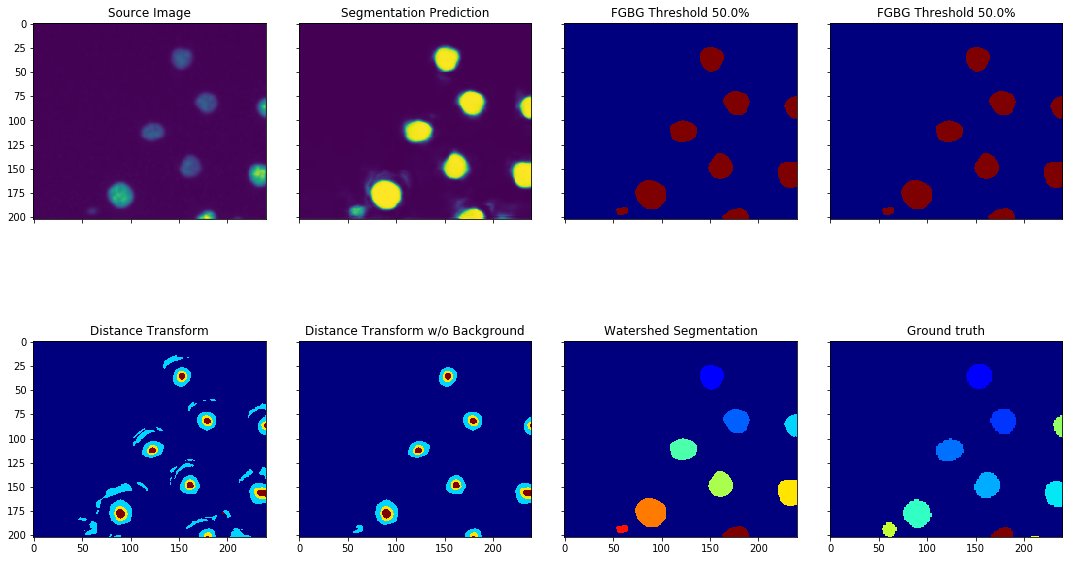

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

index = 0 #np.random.randint(low=0, high=1)
frame = 11 #np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)



fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

fg_thresh_90 = test_images_fgbg[..., 1] > 0.5
fg_thresh_90 = np.expand_dims(fg_thresh_90.astype('int16'), axis=-1)
ax[3].imshow(fg_thresh_90[index, frame, ..., 0], cmap='jet')
ax[3].set_title('FGBG Threshold {}%'.format(0.5 * 100))

ax[4].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform')

ax[5].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Distance Transform w/o Background')

ax[6].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[6].set_title('Watershed Segmentation')

ax[7].imshow(y_test[index, frame, ..., 0], cmap='jet')
ax[7].set_title('Ground truth')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Make Predictions on ISBI Data for Metrics

In [ ]:
###### FOR ISBI Challenge Datasets

# Define data to load (raw images from trk test files)  
RAW_BASE_DIR = '/data/data/ISBI_Tracking_Challenge/tracks'

raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'ISBI_HeLa_Chal_GT.trks')
raw_trks_MSC  = os.path.join(RAW_BASE_DIR, 'ISBI_MSC_resized_Chal_GT_normalized.trks')
raw_trks_U373 = os.path.join(RAW_BASE_DIR, 'ISBI_U373_Chal_GT.trks')

#raw_trks_files = [raw_trks_HeLa, raw_trks_MSC, raw_trks_U373]
raw_trks_files = [raw_trks_HeLa]

# Define where segmentations will be saved
SEG_BASE_DIR = '/data/track_data/Final_Benchmarks/ISBI_DC_SEG/Watershed/HeLa_segmentations'
                             
DC_seg_HeLa  = os.path.join(SEG_BASE_DIR, 'HeLa/')
DC_seg_MSC   = os.path.join(SEG_BASE_DIR, 'MSC/')
DC_seg_U373  = os.path.join(SEG_BASE_DIR, 'U373/')

#DC_seg_folders = [DC_seg_HeLa, DC_seg_MSC, DC_seg_U373]
DC_seg_folders = [DC_seg_HeLa]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [ ]:
# Instantiate new models for any image size

from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=(None, None, 1),
    last_only=False)

fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')


watershed_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=(None, None, 1))

watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model.h5')

In [ ]:
# Run Predict for metric information only

CELL_TYPE_NAME = ['HeLa']
threshold = 0.9

from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max

import tarfile
import pathlib
import tempfile
import json
import pandas as pd
from io import BytesIO


def load_trks(filename):
    """Load a trk/trks file.

    Args:
        trks_file: full path to the file including .trk/.trks

    Returns:
        A dictionary with raw, tracked, and lineage data
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

    return {'X': raw, 'y': tracked}


Lstats_AllDatasets = []

# Go through each Dataset
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    raw, tracked = trks['X'], trks['y']
    
    # Create an array for the new annotations
    y_new = np.zeros(tracked.shape)
                
    Lstats_allmovies = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):

        Lstats = []
        # Predict on the raw data
        for frame_num, frame in enumerate(movie):
            
            image = np.expand_dims(frame, axis=0)
             
            test_image = watershed_model.predict(image)[-1]
            test_image_fgbg = fgbg_model.predict(image)[-1]

            # Postprocessing
            # Collapse predictions into semantic segmentation mask        
            max_image = np.argmax(test_image, axis=-1)
            argmax_image = np.expand_dims(max_image, axis=-1)
        
            # threshold the foreground/background
            # and remove background from watershed transform
            fg_thresh = test_image_fgbg[..., 1] > threshold

            fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
            argmax_image_post_fgbg = argmax_image * fg_thresh
        
            # Apply watershed method with the distance transform as seed
            image = fg_thresh[..., 0]
            distance = argmax_image_post_fgbg[..., 0]

            local_maxi = peak_local_max(test_image[..., -1], min_distance=15, 
                                        exclude_border=False, indices=False, labels=image)

            markers = label(local_maxi)
            segments = watershed(-distance, markers, mask=image)
            watershed_image = np.expand_dims(segments, axis=-1)
            
            # Remove small objects from GT for comparison
            small_objects_threshold=50
            GT_image = trks['y'][batch_num, frame_num, :, :, :]
            GT_image = np.expand_dims(GT_image, axis=0)
            GT_image = morphology.remove_small_objects(GT_image.astype('uint16'), min_size=small_objects_threshold)
            
            # Accuracy from metrics package
            filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(batch_num)
            
            m = metrics.Metrics(model_name = filename)
            m.calc_object_stats(GT_image, watershed_image)
            
            # Store results
            y_new[batch_num, frame_num, :, :, :] = watershed_image

            Lstats.append(m.stats)
            
    # Save results of this batch before moving on to the next
    filename = os.path.join(DC_seg_folders[set_num], 'all_batches.trks')
    filename = pathlib.Path(filename)

    with tarfile.open(str(filename), 'w') as trks:
        with tempfile.NamedTemporaryFile() as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            trks.add(raw_file.name, 'raw.npy')

        with tempfile.NamedTemporaryFile() as tracked_file:
            np.save(tracked_file, y_new)
            tracked_file.flush()
            trks.add(tracked_file.name, 'tracked.npy')
                
        
        Lstats_allmovies.append(Lstats)
        
    Lstats_AllDatasets.append(Lstats_allmovies)
    
    
#df_HeLa   = pd.concat(Lstats_AllDatasets[0])
df_HeLa = pd.concat([pd.concat(Lstats_AllDatasets[0][0]) , pd.concat(Lstats_AllDatasets[0][1])])


In [ ]:
CELL_TYPE_DF = [df_HeLa]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)